In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38263")
client

<Client: 'tcp://127.0.0.1:38263' processes=4 threads=4, memory=11.72 GiB>

In [2]:
import numpy as np
import xarray as xr
import gcm_filters
from xgcm.grid import Grid
import s3fs
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/GIGATL/"
gigatl_datasets = {
    ds: xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True)
    for ds in ["Region01/surf/fma"]
}

gigatl_datasets

{'Region01/surf/fma': <xarray.Dataset>
 Dimensions:     (eta_rho: 1489, eta_v: 1488, time: 2280, xi_rho: 1491, xi_u: 1490)
 Dimensions without coordinates: eta_rho, eta_v, time, xi_rho, xi_u
 Data variables: (12/13)
     angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
     f           (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
     h           (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
     lat         (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
     lon         (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
     ocean_time  (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
     ...          ...
     pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
     salt        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 1489, 1491), meta=np.ndarray>
     temp 

In [4]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########

In [5]:
ds = adjust_coords(gigatl_datasets['Region01/surf/fma']
                  ).isel(eta_rho=slice(100,900),eta_v=slice(100,900),
                         xi_rho=slice(-800,None),xi_u=slice(-800,None)
                        )
ds

<xarray.Dataset>
Dimensions:     (eta_rho: 800, eta_v: 800, time: 2280, xi_rho: 800, xi_u: 800)
Coordinates:
    lat         (eta_rho, xi_rho) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    lon         (eta_rho, xi_rho) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
Dimensions without coordinates: eta_rho, eta_v, time, xi_rho, xi_u
Data variables:
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    ocean_time  (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(800, 800), meta=np.ndarray>
    salt        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 800, 800), meta=np.ndarray>
    temp        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 800, 800), meta=np.ndarray>
    u           (time, eta_rho, xi_u) float32 dask.array<chunksize=(24, 800, 800), meta=np.ndarray>
    v           (time, eta_v, xi_rho) float32 dask.array<chunksize=(24, 800, 800), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 800, 800), meta=np.ndarray>
Attributes:
    xgcm-Grid:  <xgcm.Grid>\nxi Axis (not periodic, boundary=None):\n  * cent...

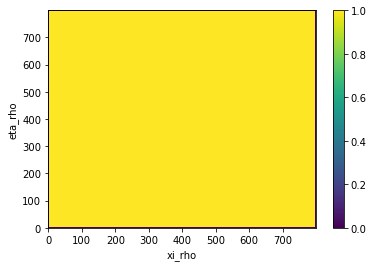

In [6]:
pad = 1
# mask = np.zeros((len(ds.y)+int(2*pad),len(ds.x)+int(2*pad)))
mask = np.ma.masked_invalid(ds.temp.where(ds.temp==0.).isel(time=0)).mask
mask[:2,:] = 0.
mask[-2:,:] = 0.
mask[:,:2] = 0.
mask[:,-2:] = 0.
wet_mask = xr.DataArray(mask, dims=ds.temp.isel(time=0).dims,
                        coords=ds.temp.isel(time=0).coords
                       )
wet_mask.plot()

In [12]:
grid = ds.attrs['xgcm-Grid']

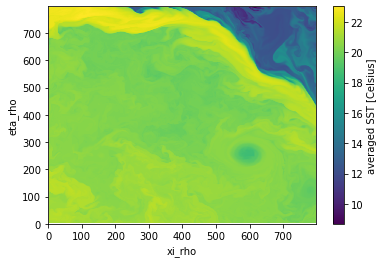

In [42]:
sst = ds.temp.isel(time=0).isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1))
sst.where(wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1))!=0.).plot()

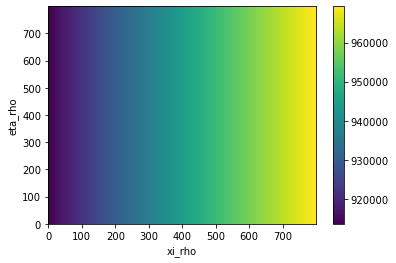

In [23]:
# area = (dxC * dyC)
area = (ds.pm**-1 * ds.pn**-1)
area.plot()

In [40]:
print(np.isnan(area.values).any())

False


# REGULAR_WITH_LAND

In [24]:
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED)

['area', 'wet_mask']

In [30]:
factor = 50
dx_min = 1
filter_shape = gcm_filters.FilterShape.GAUSSIAN

filter_50km_regular = gcm_filters.Filter(
    filter_scale=factor,
    dx_min=dx_min,
    filter_shape=filter_shape,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)), 
               'wet_mask': wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1))}
)
filter_50km_regular

# filter_50km_regular = gcm_filters.Filter(
#     filter_scale=factor,
#     dx_min=dx_min,
#     filter_shape=filter_shape,
#     grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
#     grid_vars={
#         'wet_mask': wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)), 
#     }
# )
# filter_50km_regular

Filter(filter_scale=50, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=56, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

In [31]:
SST_filtered_to_50km_regular = filter_50km_regular.apply(sst.reset_coords(drop=True), 
                                                         dims=['eta_rho', 'xi_rho']
                                                        ).compute()
SST_filtered_to_50km_regular.plot()

TypeError: The numpy boolean negative, the `-` operator, is not supported, use the `~` operator or the logical_not function instead.

In [ ]:
vmin = -25
vmax = 25

fig,axs = plt.subplots(1,3,figsize=(25,8))

ds.temp.where(mask!=0.).isel(time=0).isel(eta_rho=slice(pad+1,-2-pad),
                                          xi_rho=slice(pad+1,-2-pad)).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': r'$^\circ$C'}
)
axs[0].set(title='unfiltered SST')

SST_filtered_to_50km_regular.isel(eta_rho=slice(pad+1,-pad-1),xi_rho=slice(pad+1,-pad-1)).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': r'$^\circ$C'}
)
axs[1].set(title='SST filtered to 50km', ylabel='')

(ds.temp.where(mask!=0.).isel(time=0).isel(eta_rho=slice(pad+1,-2-pad),
                                           xi_rho=slice(pad+1,-2-pad))
 - SST_filtered_to_50km_regular.isel(eta_rho=slice(pad+1,-pad-1),xi_rho=slice(pad+1,-pad-1))
).isel(eta_rho=slice(None,None),xi_rho=slice(None,None)).plot(
    ax=axs[2], 
    vmax=5, vmin=-5,
    cmap='seismic', cbar_kwargs={'label': r'$^\circ$C'}
)
axs[2].set(title='(unfiltered - filtered) SST', ylabel='');

# IRREGULAR_WITH_LAND

In [32]:
filter_scale = 50000   # 50 km

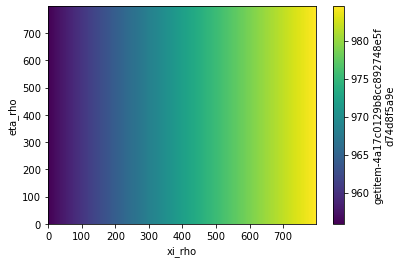

In [13]:
# dxw = wet_mask.copy() * np.nan
dxw = xr.DataArray(grid.interp(ds.pm**-1,
                               'xi').isel(eta_rho=slice(None,-1)).data,  # x-spacing centered at western cell edge
                   dims=['eta_rho','xi_rho'], 
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)).coords
                  )
dxw[:,:] = np.nan_to_num(dxw[:,:],nan=1)
# dyw = wet_mask.copy() * np.nan
dyw = xr.DataArray(grid.interp(ds.pn**-1,
                               'xi').isel(eta_rho=slice(None,-1)).data,  # y-spacing centered at western cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)).coords
                  )
dyw[:,:] = np.nan_to_num(dyw[:,:],nan=1)
# dxs = wet_mask.copy() * np.nan
dxs = xr.DataArray(grid.interp(ds.pm**-1,
                               'eta').isel(xi_rho=slice(None,-1)).data,  # x-spacing centered at southern cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)).coords
                  ) 
dxs[:,:] = np.nan_to_num(dxs[:,:],nan=1)
# dys = wet_mask.copy() * np.nan
dys = xr.DataArray(grid.interp(ds.pn**-1,
                               'eta').isel(xi_rho=slice(None,-1)).data,  # y-spacing centered at southern cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)).coords
                  ) 
dys[:,:] = np.nan_to_num(dys[:,:],nan=1)
dxw.plot()

In [33]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min()
            )
dx_min = dx_min.values
dx_min

array(955.87683, dtype=float32)

In [34]:
kappa_w = xr.ones_like(wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)))
# kappa_w[pad:-pad,pad:-pad] = 1.
kappa_s = xr.ones_like(wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1))) 
# kappa_s[pad:-pad,pad:-pad] = 1.

In [35]:
filter_50km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)), 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 
        'area': area.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)), 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)
filter_50km

Filter(filter_scale=50000, dx_min=array(955.87683, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=58, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

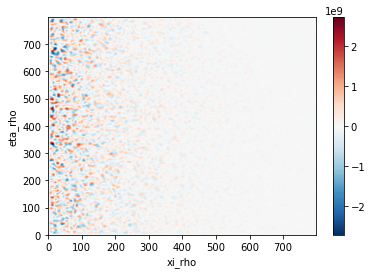

In [36]:
sst = ds.temp.isel(time=0).isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1))

SST_filtered_to_50km = filter_50km.apply(sst.reset_coords(drop=True), dims=['eta_rho', 'xi_rho']
                                        ).compute()
SST_filtered_to_50km.plot()

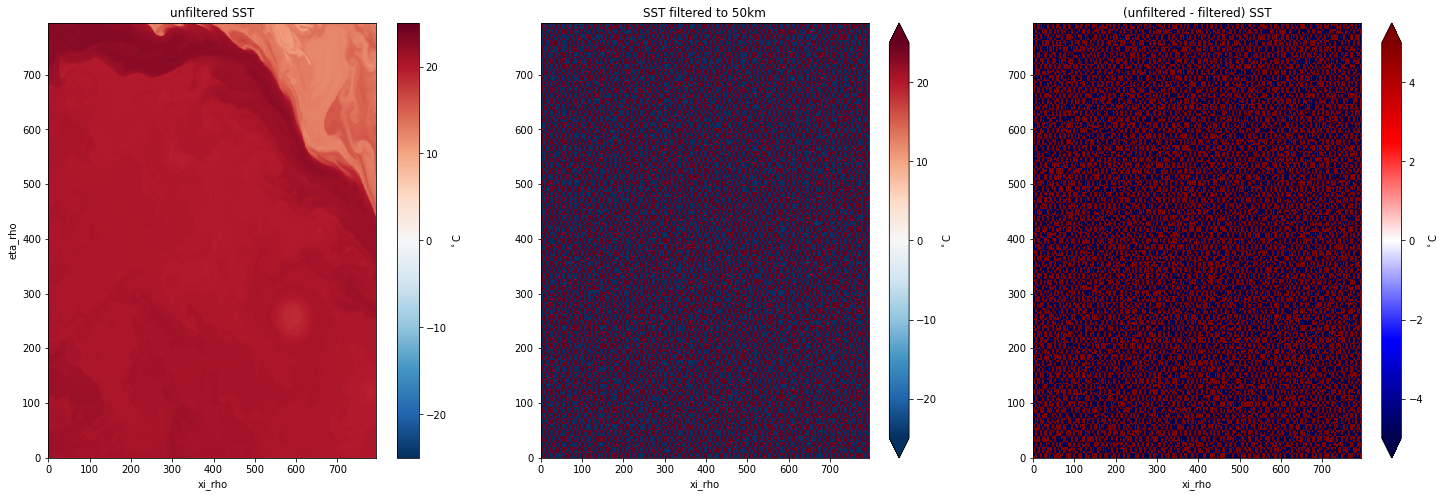

In [37]:
vmin = -25
vmax = 25

fig,axs = plt.subplots(1,3,figsize=(25,8))

ds.temp.where(mask!=0.).isel(time=0).isel(eta_rho=slice(pad+1,-2-pad),
                                          xi_rho=slice(pad+1,-2-pad)).plot(
    ax=axs[0], 
    vmin=vmin, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': r'$^\circ$C'}
)
axs[0].set(title='unfiltered SST')

SST_filtered_to_50km.isel(eta_rho=slice(pad+1,-pad-1),xi_rho=slice(pad+1,-pad-1)).plot(
    ax=axs[1], 
    vmin=vmin, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': r'$^\circ$C'}
)
axs[1].set(title='SST filtered to 50km', ylabel='')

(ds.temp.where(mask!=0.).isel(time=0).isel(eta_rho=slice(pad+1,-2-pad),
                                           xi_rho=slice(pad+1,-2-pad))
 - SST_filtered_to_50km.isel(eta_rho=slice(pad+1,-pad-1),xi_rho=slice(pad+1,-pad-1))
).isel(eta_rho=slice(None,None),xi_rho=slice(None,None)).plot(
    ax=axs[2], 
    vmax=5, vmin=-5,
    cmap='seismic', cbar_kwargs={'label': r'$^\circ$C'}
)
axs[2].set(title='(unfiltered - filtered) SST', ylabel='');